<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Impronte/AttaccoScanner/Attacchi_enhancement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

## Import librerie

In [2]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys

from torchvision.transforms.functional import InterpolationMode

from torch.utils.data import TensorDataset, DataLoader

import cv2
from google.colab.patches import cv2_imshow

from typing import Optional

##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.10.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Def path

In [122]:
#scanner
scanner_name = 'HiScan'

#load modello
path_model = F"/content/gdrive/My Drive/Scanner/{scanner_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

#predizioni testset originale
pd_preds=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}_con_normalize.xlsx'

##Collegamento google drive

In [5]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Transforms

In [123]:
#transf_init=transforms.Resize(size=(1000,1000),interpolation=InterpolationMode.NEAREST)

data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
transf_resize=transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST)
transf_load= transforms.Compose([transforms.ToTensor(),
                                 #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
trans_norm=transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


#**Dataset**

##Caricamento dataset

In [124]:
test_dataset = datasets.ImageFolder(pathTestset,transform=transf_load)
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [125]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)

##Nomi classi

In [126]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


##Min Max dataset

In [127]:
_min,_max=0,1

##transf_init

In [128]:
a,_=next(iter(testgen))
size_init=np.array(a.shape[2:4])
transf_init=transforms.Resize(size=(size_init[0],size_init[1]),interpolation=InterpolationMode.NEAREST)

#**Riduzione dataset**

In [129]:
test_dataset.samples=test_dataset.samples[1500:]

dim_set=len(test_dataset)
print(dim_set)

1000


In [130]:
test_dataset.samples=[test_dataset.samples[i] for i in range(len(test_dataset)) if 'Latex' in test_dataset.samples[i][0]]

dim_set=len(test_dataset)
print(dim_set)

250


eseguire solo se si vuole provare con poche img

In [131]:
test_dataset.samples=test_dataset.samples[:10]

dim_set=len(test_dataset)
print(dim_set)

10


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [132]:
if scanner_name=='DigitalPersona':
  model = models.densenet201(pretrained=True,progress=True)
else: model = models.vgg19(pretrained=True,progress=True)

#print(model)

##Aggiunta classificatore

In [133]:
if scanner_name=='DigitalPersona':
  model.classifier=nn.Linear(1920,2) #per densenet201
else: model.classifier[6]=nn.Linear(4096,2) #per vgg19


#print(model) 

##Load pesi

In [134]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Def funzioni**

##enhanc

###fun

In [135]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov 4 19:46:32 2020

@author: utkarsh
"""

import numpy as np
import cv2
from scipy import signal
from scipy import ndimage
import math
import scipy

class FingerprintImageEnhancer(object):
    def __init__(self, ridge_segment_blksze=32, ridge_segment_thresh=0.1, gradient_sigma=1, block_sigma=7, orient_smooth_sigma=7,
                 ridge_freq_blksze=38, ridge_freq_windsze=5, min_wave_length=8, max_wave_length=15, kx=0.65, ky=0.65, angleInc=3.0, ridge_filter_thresh=-3):
        self.ridge_segment_blksze = ridge_segment_blksze
        self.ridge_segment_thresh = ridge_segment_thresh
        self.gradient_sigma = gradient_sigma
        self.block_sigma = block_sigma
        self.orient_smooth_sigma = orient_smooth_sigma
        self.ridge_freq_blksze = ridge_freq_blksze
        self.ridge_freq_windsze = ridge_freq_windsze
        self.min_wave_length = min_wave_length
        self.max_wave_length = max_wave_length
        self.kx = kx
        self.ky = ky
        self.angleInc = angleInc
        self.ridge_filter_thresh = ridge_filter_thresh


        self._mask = []
        self._normim = []
        self._orientim = []
        self._mean_freq = []
        self._median_freq = []
        self._freq = []
        self._freqim = []
        self._binim = []

    def __normalise(self, img, mean, std):
        normed = (img - np.mean(img)) / (np.std(img))
        return (normed)

    def __ridge_segment(self, img):
        # RIDGESEGMENT - Normalises fingerprint image and segments ridge region
        #
        # Function identifies ridge regions of a fingerprint image and returns a
        # mask identifying this region.  It also normalises the intesity values of
        # the image so that the ridge regions have zero mean, unit standard
        # deviation.
        #
        # This function breaks the image up into blocks of size blksze x blksze and
        # evaluates the standard deviation in each region.  If the standard
        # deviation is above the threshold it is deemed part of the fingerprint.
        # Note that the image is normalised to have zero mean, unit standard
        # deviation prior to performing this process so that the threshold you
        # specify is relative to a unit standard deviation.
        #
        # Usage:   [normim, mask, maskind] = ridgesegment(im, blksze, thresh)
        #
        # Arguments:   im     - Fingerprint image to be segmented.
        #              blksze - Block size over which the the standard
        #                       deviation is determined (try a value of 16).
        #              thresh - Threshold of standard deviation to decide if a
        #                       block is a ridge region (Try a value 0.1 - 0.2)
        #
        # Ouput:     normim - Image where the ridge regions are renormalised to
        #                       have zero mean, unit standard deviation.
        #              mask   - Mask indicating ridge-like regions of the image,
        #                       0 for non ridge regions, 1 for ridge regions.
        #              maskind - Vector of indices of locations within the mask.
        #
        # Suggested values for a 500dpi fingerprint image:
        #
        #   [normim, mask, maskind] = ridgesegment(im, 16, 0.1)
        #
        # See also: RIDGEORIENT, RIDGEFREQ, RIDGEFILTER

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk
        rows, cols = img.shape
        im = self.__normalise(img, 0, 1)  # normalise to get zero mean and unit standard deviation

        new_rows = np.int(self.ridge_segment_blksze * np.ceil((np.float(rows)) / (np.float(self.ridge_segment_blksze))))
        new_cols = np.int(self.ridge_segment_blksze * np.ceil((np.float(cols)) / (np.float(self.ridge_segment_blksze))))

        padded_img = np.zeros((new_rows, new_cols))
        stddevim = np.zeros((new_rows, new_cols))
        padded_img[0:rows][:, 0:cols] = im
        for i in range(0, new_rows, self.ridge_segment_blksze):
            for j in range(0, new_cols, self.ridge_segment_blksze):
                block = padded_img[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze]

                stddevim[i:i + self.ridge_segment_blksze][:, j:j + self.ridge_segment_blksze] = np.std(block) * np.ones(block.shape)

        stddevim = stddevim[0:rows][:, 0:cols]
        self._mask = stddevim > self.ridge_segment_thresh
        mean_val = np.mean(im[self._mask])
        std_val = np.std(im[self._mask])
        self._normim = (im - mean_val) / (std_val)

    def __ridge_orient(self):
        # RIDGEORIENT - Estimates the local orientation of ridges in a fingerprint
        #
        # Usage:  [orientim, reliability, coherence] = ridgeorientation(im, gradientsigma,...
        #                                             blocksigma, ...
        #                                             orientsmoothsigma)
        #
        # Arguments:  im                - A normalised input image.
        #             gradientsigma     - Sigma of the derivative of Gaussian
        #                                 used to compute image gradients.
        #             blocksigma        - Sigma of the Gaussian weighting used to
        #                                 sum the gradient moments.
        #             orientsmoothsigma - Sigma of the Gaussian used to smooth
        #                                 the final orientation vector field.
        #                                 Optional: if ommitted it defaults to 0
        #
        # Output:    orientim          - The orientation image in radians.
        #                                 Orientation values are +ve clockwise
        #                                 and give the direction *along* the
        #                                 ridges.
        #             reliability       - Measure of the reliability of the
        #                                 orientation measure.  This is a value
        #                                 between 0 and 1. I think a value above
        #                                 about 0.5 can be considered 'reliable'.
        #                                 reliability = 1 - Imin./(Imax+.001);
        #             coherence         - A measure of the degree to which the local
        #                                 area is oriented.
        #                                 coherence = ((Imax-Imin)./(Imax+Imin)).^2;
        #
        # With a fingerprint image at a 'standard' resolution of 500dpi suggested
        # parameter values might be:
        #
        #    [orientim, reliability] = ridgeorient(im, 1, 3, 3);
        #
        # See also: RIDGESEGMENT, RIDGEFREQ, RIDGEFILTER

        ### REFERENCES

        # May 2003      Original version by Raymond Thai,
        # January 2005  Reworked by Peter Kovesi
        # October 2011  Added coherence computation and orientsmoothsigma made optional
        #
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows,cols = self._normim.shape
        #Calculate image gradients.
        sze = np.fix(6*self.gradient_sigma)
        if np.remainder(sze,2) == 0:
            sze = sze+1

        gauss = cv2.getGaussianKernel(np.int(sze),self.gradient_sigma)
        f = gauss * gauss.T

        fy,fx = np.gradient(f)                               #Gradient of Gaussian

        Gx = signal.convolve2d(self._normim, fx, mode='same')
        Gy = signal.convolve2d(self._normim, fy, mode='same')

        Gxx = np.power(Gx,2)
        Gyy = np.power(Gy,2)
        Gxy = Gx*Gy

        #Now smooth the covariance data to perform a weighted summation of the data.
        sze = np.fix(6*self.block_sigma)

        gauss = cv2.getGaussianKernel(np.int(sze), self.block_sigma)
        f = gauss * gauss.T

        Gxx = ndimage.convolve(Gxx,f)
        Gyy = ndimage.convolve(Gyy,f)
        Gxy = 2*ndimage.convolve(Gxy,f)

        # Analytic solution of principal direction
        denom = np.sqrt(np.power(Gxy,2) + np.power((Gxx - Gyy),2)) + np.finfo(float).eps

        sin2theta = Gxy/denom                   # Sine and cosine of doubled angles
        cos2theta = (Gxx-Gyy)/denom


        if self.orient_smooth_sigma:
            sze = np.fix(6*self.orient_smooth_sigma)
            if np.remainder(sze,2) == 0:
                sze = sze+1
            gauss = cv2.getGaussianKernel(np.int(sze), self.orient_smooth_sigma)
            f = gauss * gauss.T
            cos2theta = ndimage.convolve(cos2theta,f)                   # Smoothed sine and cosine of
            sin2theta = ndimage.convolve(sin2theta,f)                   # doubled angles

        self._orientim = np.pi/2 + np.arctan2(sin2theta,cos2theta)/2

    def __ridge_freq(self):
        # RIDGEFREQ - Calculates a ridge frequency image
        #
        # Function to estimate the fingerprint ridge frequency across a
        # fingerprint image. This is done by considering blocks of the image and
        # determining a ridgecount within each block by a call to FREQEST.
        #
        # Usage:
        #  [freqim, medianfreq] =  ridgefreq(im, mask, orientim, blksze, windsze, ...
        #                                    minWaveLength, maxWaveLength)
        #
        # Arguments:
        #         im       - Image to be processed.
        #         mask     - Mask defining ridge regions (obtained from RIDGESEGMENT)
        #         orientim - Ridge orientation image (obtained from RIDGORIENT)
        #         blksze   - Size of image block to use (say 32)
        #         windsze  - Window length used to identify peaks. This should be
        #                    an odd integer, say 3 or 5.
        #         minWaveLength,  maxWaveLength - Minimum and maximum ridge
        #                     wavelengths, in pixels, considered acceptable.
        #
        # Output:
        #         freqim     - An image  the same size as im with  values set to
        #                      the estimated ridge spatial frequency within each
        #                      image block.  If a  ridge frequency cannot be
        #                      found within a block, or cannot be found within the
        #                      limits set by min and max Wavlength freqim is set
        #                      to zeros within that block.
        #         medianfreq - Median frequency value evaluated over all the
        #                      valid regions of the image.
        #
        # Suggested parameters for a 500dpi fingerprint image
        #   [freqim, medianfreq] = ridgefreq(im,orientim, 32, 5, 5, 15);
        #

        # See also: RIDGEORIENT, FREQEST, RIDGESEGMENT

        # Reference:
        # Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
        # Algorithm and performance evaluation. IEEE Transactions on Pattern
        # Analysis and Machine Intelligence 20, 8 (1998), 777 789.

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows, cols = self._normim.shape
        freq = np.zeros((rows, cols))

        for r in range(0, rows - self.ridge_freq_blksze, self.ridge_freq_blksze):
            for c in range(0, cols - self.ridge_freq_blksze, self.ridge_freq_blksze):
                blkim = self._normim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]
                blkor = self._orientim[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze]

                freq[r:r + self.ridge_freq_blksze][:, c:c + self.ridge_freq_blksze] = self.__frequest(blkim, blkor)

        self._freq = freq * self._mask
        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)

        ind = np.array(ind)
        ind = ind[1, :]

        non_zero_elems_in_freq = freq_1d[0][ind]

        if(len(non_zero_elems_in_freq) != 0):
            self._mean_freq = np.mean(non_zero_elems_in_freq)
            self._median_freq = np.median(non_zero_elems_in_freq)  # does not work properly
        else:
            self._mean_freq = 0
            self._median_freq = 0  # does not work properly
        self._freq = self._mean_freq * self._mask

    def __frequest(self, blkim, blkor):
        # FREQEST - Estimate fingerprint ridge frequency within image block
        #
        # Function to estimate the fingerprint ridge frequency within a small block
        # of a fingerprint image.  This function is used by RIDGEFREQ
        #
        # Usage:
        #  freqim =  freqest(im, orientim, windsze, minWaveLength, maxWaveLength)
        #
        # Arguments:
        #         im       - Image block to be processed.
        #         orientim - Ridge orientation image of image block.
        #         windsze  - Window length used to identify peaks. This should be
        #                    an odd integer, say 3 or 5.
        #         minWaveLength,  maxWaveLength - Minimum and maximum ridge
        #                     wavelengths, in pixels, considered acceptable.
        #
        # Output:
        #         freqim    - An image block the same size as im with all values
        #                     set to the estimated ridge spatial frequency.  If a
        #                     ridge frequency cannot be found, or cannot be found
        #                     within the limits set by min and max Wavlength
        #                     freqim is set to zeros.
        #
        # Suggested parameters for a 500dpi fingerprint image
        #   freqim = freqest(im,orientim, 5, 5, 15);
        #
        # See also:  RIDGEFREQ, RIDGEORIENT, RIDGESEGMENT

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        rows, cols = np.shape(blkim)

        # Find mean orientation within the block. This is done by averaging the
        # sines and cosines of the doubled angles before reconstructing the
        # angle again.  This avoids wraparound problems at the origin.

        cosorient = np.mean(np.cos(2 * blkor))
        sinorient = np.mean(np.sin(2 * blkor))
        orient = math.atan2(sinorient, cosorient) / 2

        # Rotate the image block so that the ridges are vertical

        # ROT_mat = cv2.getRotationMatrix2D((cols/2,rows/2),orient/np.pi*180 + 90,1)
        # rotim = cv2.warpAffine(im,ROT_mat,(cols,rows))
        rotim = scipy.ndimage.rotate(blkim, orient / np.pi * 180 + 90, axes=(1, 0), reshape=False, order=3,
                                     mode='nearest')

        # Now crop the image so that the rotated image does not contain any
        # invalid regions.  This prevents the projection down the columns
        # from being mucked up.

        cropsze = int(np.fix(rows / np.sqrt(2)))
        offset = int(np.fix((rows - cropsze) / 2))
        rotim = rotim[offset:offset + cropsze][:, offset:offset + cropsze]

        # Sum down the columns to get a projection of the grey values down
        # the ridges.

        proj = np.sum(rotim, axis=0)
        dilation = scipy.ndimage.grey_dilation(proj, self.ridge_freq_windsze, structure=np.ones(self.ridge_freq_windsze))

        temp = np.abs(dilation - proj)

        peak_thresh = 2

        maxpts = (temp < peak_thresh) & (proj > np.mean(proj))
        maxind = np.where(maxpts)

        rows_maxind, cols_maxind = np.shape(maxind)

        # Determine the spatial frequency of the ridges by divinding the
        # distance between the 1st and last peaks by the (No of peaks-1). If no
        # peaks are detected, or the wavelength is outside the allowed bounds,
        # the frequency image is set to 0

        if (cols_maxind < 2):
            return(np.zeros(blkim.shape))
        else:
            NoOfPeaks = cols_maxind
            waveLength = (maxind[0][cols_maxind - 1] - maxind[0][0]) / (NoOfPeaks - 1)
            if waveLength >= self.min_wave_length and waveLength <= self.max_wave_length:
                return(1 / np.double(waveLength) * np.ones(blkim.shape))
            else:
                return(np.zeros(blkim.shape))

    def __ridge_filter(self):
        # RIDGEFILTER - enhances fingerprint image via oriented filters
        #
        # Function to enhance fingerprint image via oriented filters
        #
        # Usage:
        #  newim =  ridgefilter(im, orientim, freqim, kx, ky, showfilter)
        #
        # Arguments:
        #         im       - Image to be processed.
        #         orientim - Ridge orientation image, obtained from RIDGEORIENT.
        #         freqim   - Ridge frequency image, obtained from RIDGEFREQ.
        #         kx, ky   - Scale factors specifying the filter sigma relative
        #                    to the wavelength of the filter.  This is done so
        #                    that the shapes of the filters are invariant to the
        #                    scale.  kx controls the sigma in the x direction
        #                    which is along the filter, and hence controls the
        #                    bandwidth of the filter.  ky controls the sigma
        #                    across the filter and hence controls the
        #                    orientational selectivity of the filter. A value of
        #                    0.5 for both kx and ky is a good starting point.
        #         showfilter - An optional flag 0/1.  When set an image of the
        #                      largest scale filter is displayed for inspection.
        #
        # Output:
        #         newim    - The enhanced image
        #
        # See also: RIDGEORIENT, RIDGEFREQ, RIDGESEGMENT

        # Reference:
        # Hong, L., Wan, Y., and Jain, A. K. Fingerprint image enhancement:
        # Algorithm and performance evaluation. IEEE Transactions on Pattern
        # Analysis and Machine Intelligence 20, 8 (1998), 777 789.

        ### REFERENCES

        # Peter Kovesi
        # School of Computer Science & Software Engineering
        # The University of Western Australia
        # pk at csse uwa edu au
        # http://www.csse.uwa.edu.au/~pk

        im = np.double(self._normim)
        rows, cols = im.shape
        newim = np.zeros((rows, cols))
        freq_1d = np.reshape(self._freq, (1, rows * cols))
        ind = np.where(freq_1d > 0)
        
        ind = np.array(ind)
        ind = ind[1, :]

        # Round the array of frequencies to the nearest 0.01 to reduce the
        # number of distinct frequencies we have to deal with.

        non_zero_elems_in_freq = freq_1d[0][ind]
        non_zero_elems_in_freq = np.double(np.round((non_zero_elems_in_freq * 100))) / 100
        
        unfreq = np.unique(non_zero_elems_in_freq)

        # Generate filters corresponding to these distinct frequencies and
        # orientations in 'angleInc' increments.

        sigmax = 1 / unfreq[0] * self.kx
        sigmay = 1 / unfreq[0] * self.ky

        sze = np.int(np.round(3 * np.max([sigmax, sigmay])))

        x, y = np.meshgrid(np.linspace(-sze, sze, (2 * sze + 1)), np.linspace(-sze, sze, (2 * sze + 1)))

        reffilter = np.exp(-(((np.power(x, 2)) / (sigmax * sigmax) + (np.power(y, 2)) / (sigmay * sigmay)))) * np.cos(
            2 * np.pi * unfreq[0] * x)        # this is the original gabor filter

        filt_rows, filt_cols = reffilter.shape

        angleRange = np.int(180 / self.angleInc)

        gabor_filter = np.array(np.zeros((angleRange, filt_rows, filt_cols)))

        for o in range(0, angleRange):
            # Generate rotated versions of the filter.  Note orientation
            # image provides orientation *along* the ridges, hence +90
            # degrees, and imrotate requires angles +ve anticlockwise, hence
            # the minus sign.

            rot_filt = scipy.ndimage.rotate(reffilter, -(o * self.angleInc + 90), reshape=False)
            gabor_filter[o] = rot_filt

        # Find indices of matrix points greater than maxsze from the image
        # boundary

        maxsze = int(sze)

        temp = self._freq > 0
        validr, validc = np.where(temp)

        temp1 = validr > maxsze
        temp2 = validr < rows - maxsze
        temp3 = validc > maxsze
        temp4 = validc < cols - maxsze

        final_temp = temp1 & temp2 & temp3 & temp4

        finalind = np.where(final_temp)

        # Convert orientation matrix values from radians to an index value
        # that corresponds to round(degrees/angleInc)

        maxorientindex = np.round(180 / self.angleInc)
        orientindex = np.round(self._orientim / np.pi * 180 / self.angleInc)

        # do the filtering
        for i in range(0, rows):
            for j in range(0, cols):
                if (orientindex[i][j] < 1):
                    orientindex[i][j] = orientindex[i][j] + maxorientindex
                if (orientindex[i][j] > maxorientindex):
                    orientindex[i][j] = orientindex[i][j] - maxorientindex
        finalind_rows, finalind_cols = np.shape(finalind)
        sze = int(sze)
        for k in range(0, finalind_cols):
            r = validr[finalind[0][k]]
            c = validc[finalind[0][k]]

            img_block = im[r - sze:r + sze + 1][:, c - sze:c + sze + 1]

            newim[r][c] = np.sum(img_block * gabor_filter[int(orientindex[r][c]) - 1])

        self._binim = newim < self.ridge_filter_thresh

    def enhance(self, img, resize=False, size: Optional[int]=350):
        # main function to enhance the image.
        # calls all other subroutines

        if (len(img.shape) > 2):  # convert image into gray if necessary
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if(resize):
            rows, cols = np.shape(img)
            aspect_ratio = np.double(rows) / np.double(cols)

            new_rows = size                     # randomly selected number
            new_cols = new_rows / aspect_ratio

            img = cv2.resize(img, (np.int(new_cols), np.int(new_rows)),cv2.INTER_NEAREST)

        self.__ridge_segment(img)   # normalise the image and find a ROI
        self.__ridge_orient()       # compute orientation image
        self.__ridge_freq()         # compute major frequency of ridges
        if self._mean_freq!=0:
          self.__ridge_filter()       # filter the image using oriented gabor filter
          failed=False
        else: failed=True
        #self._binim = 255 * self._binim.astype('uint8')
        return(np.array(self._binim).astype('int'),failed)

###my fun

In [136]:
#import torchvision
#from torchvision import transforms

def enhanc(img,mask,size_out : Optional[int]=0): 
  '''
  img: ndarray 1x3xnxm
  mask: ndarray nxm (same dim of size_out)
  size_out: (int) effettua un resize dell'immagine prima dell'enhancement (se 0 dà in uscita l'img con le stesse dim dell'input)
  return: img_en 1x3xnxm
  '''
  res=False
  #res=True
  r, g, b = img[0,0,:,:],img[0,1,:,:],img[0,2,:,:]
  img_g = 0.2989 * r + 0.5870 * g + 0.1140 * b
  size_init=img_g.shape
  finger_en=FingerprintImageEnhancer()
  if size_out==0: #se non voglio una dimensione specifica in uscita trasformo l'img finale con le dim iniziali
    if size_init[0]<350: res=True
    out,failed = finger_en.enhance(img=img_g,resize=res,size=350)
    if res:
      out = cv2.resize(np.array(out), (size_init[0],size_init[1]),interpolation=cv2.INTER_NEAREST)
  else:
    #inserire controllo se size_out<350
    res=True
    out,failed = finger_en.enhance(img=img_g,resize=res,size=size_out)

  size_out=out.shape[0]
  if failed==False:
    out=1-out
    img=np.zeros([1,3,size_out,size_out])
    for i in range(3):
      img[0,i,:,:]=out
    img=np.where(mask == 0.0, 1, img)
  else: 
    print("failed enhanc")

  return img

##Perturbazione

In [137]:
def compute_perturb(x,x_adv,transf_init):
  '''
    x: img originali
    x_adv: img contraddittorie
    return: pertubazioni
  '''
  #calcola la perturbazione con img 224x224
  if x_adv.shape[2]==224:
    x=np.array(transf_resize(torch.Tensor(x)))
  perturb=x_adv-x
  
  perturb=np.array(transf_init(torch.Tensor(perturb)))
  
  return perturb

##Print subplot

In [138]:
def print_subplot(perturb,x_test,y_test,preds,x_test_adv,value_preds_adv):
  '''
    perturb: perturbazioni
    x_test: img originali
    y_test: classi originali
    preds: classi predette per img originali
    x_test_adv: img contraddittoria
    value_preds_adv: probabilità predette img contraddittorie
    normalize: se True normalizza le immagini
  '''
  
  #nel seguente ciclo for si crea un vettore delle classi predette ordinato per probabilità decrescente
  for i in range(len(x_test)):#(x_test.shape[0]):
    value=value_preds_adv[i]*100
    value_sorted=sorted(value,reverse=True)
    classes=[]
    for j in range(value.size) :
      ind=np.where(value==value_sorted[j]) #restituisce l'indice in value del valore uguale a value_sorted[i], quindi è la classe
      classes.append(classes_name[ind[0][0]]) #classes è il vettore finale
    
    value_sorted=[ round(elem, 2) for elem in value_sorted ]

    val_pert=np.mean(np.abs(perturb[i]))
    pert_min,pert_max=np.min(perturb[i]),np.max(perturb[i])
    #perturb,val_pert,perturb_norm=compute_perturb(x_test,x_test_adv)
    perturb[i]=np.clip(perturb[i],0,1) #rimuovo i valori negativi poiché non posso visualizzarli
    #in seguito per ogni immagine del test set si stampa un subplot
    fig = plt.figure(figsize=[20,20])
    #plt.subplots_adjust(wspace=0.9)
    print('\033[1m'+"IMMAGINE "+'\033[1m',i) #valore END: '\033[0m'
    #originale
    ax1 = fig.add_subplot(131) #subplot con 3 righe e due colonne
    ax1.axis('off')
    #ax1.imshow(cv2.rotate(x_test[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax1.imshow(x_test[i].transpose(1,2,0))
    ax1.title.set_text("ORIGINALE\nclasse reale: "+classes_name[np.argmax(y_test[i])]+"\nclasse predetta: "+str(preds[i]))
    #perturbazione
    ax2 = fig.add_subplot(132)
    #ax2.imshow(cv2.rotate(perturb_norm[i],cv2.cv2.ROTATE_90_CLOCKWISE))
    ax2.imshow(perturb[i].transpose(1,2,0),cmap='gray')
    #ax2.imshow(perturb[i],cmap='gray')
    ax2.axis('off')
    ax2.title.set_text("PERTURBAZIONE\nvalore medio: "+str(round(val_pert,4))+"\nmin: "+str(pert_min)+"\nmax: "+str(pert_max))
    #perturbata
    ax3 = fig.add_subplot(133)
    #ax3.imshow(cv2.rotate(x_test_adv[i],cv2.cv2.ROTATE_90_CLOCKWISE))#,aspect='auto')
    ax3.imshow(x_test_adv[i].transpose(1,2,0))
    ax3.axis('off')
    ax3.title.set_text("PERTURBATA\nclassi predette: "+str(classes)+"\ncon valori: "+str(value_sorted))
    plt.show()

##Testing

In [139]:
def test_average(classifier,input,transf_init):
  '''
  model: model trained
  test_loader: dataloader 
  return: pred: classe predetta, probabilities, values
  '''

  def calc_size(n):
    '''
    n: int 
    return: 80% of n
    '''
    return tuple(int(np.ceil(i * (80/100))) for i in n)

  preds=[]
  #value=[]
  prob=nn.Softmax(dim=0)
  
  if input.shape[2]==224:
    input=transf_init(input)

  n=input.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
  crops=crop_transform(input)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop) #resize 224
    outputs = classifier.predict(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  values=[live,spoof]
  predicted=np.argmax(values)
  probabilities=prob(torch.Tensor(values)).numpy()

  return predicted,probabilities,values

##mask

In [140]:
def compute_mask(img,dim_contours=10,n_rect=2):
  '''
  img: tensor 1x3xnxm
  dim_contours: larghezza dei contorni da tracciare (consigliati 10 in generale e 8 per Latex)
  n_rect: dimensione rect di getStructuringElement (consigliata 2 in generale e 1 per Latex)
  '''
  #img iniziale [0,1]
  img=np.array(img[0])
  img=img.transpose(1,2,0)

  #trasforma in gray
  r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  #scala in [0,255]
  gray = (gray - np.min(gray)) / (np.max(gray) - np.min(gray))
  gray=gray*255
  gray=gray.astype('uint8')
  #cv2_imshow(gray)
  #calcola immagine binaria
  ret, imgf = cv2.threshold(gray, 0,255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

  # Morph open to remove noise
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n_rect,n_rect))
  imgf = cv2.morphologyEx(imgf, cv2.MORPH_OPEN, kernel, iterations=1)
  #cv2_imshow(imgf)
  image_contours = np.zeros((imgf.shape[1],
                            imgf.shape[0]),
                            np.uint8)

  image_binary = np.zeros((imgf.shape[1],
                          imgf.shape[0]),
                          np.uint8)

  #cerca i contorni nell'immagine binaria
  contours =cv2.findContours(imgf, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

  cv2.drawContours(image_contours,
                      contours, -1,
                      (255,255), dim_contours) 
  

  #image_contours=cv2.GaussianBlur(image_contours, (3,3), 0)
  #cv2_imshow(image_contours)
  contours = cv2.findContours(image_contours, cv2.RETR_LIST,
                            cv2.CHAIN_APPROX_SIMPLE)[0]
  #disegna solo il contorno più esterno
  cv2.drawContours(image_binary, [max(contours, key = cv2.contourArea)],
                  -1, (255, 255),-1)
  #cv2_imshow(image_binary)
  #restituisce immagine [0,1]
  return image_binary/255

##Save/read

In [141]:
def save_read(x,classifier,transf_init):
  '''
  x: 3xnxm ndarray
  classifier
  transf_init
  return: probabilities before & after
  '''
  _,p_before,_=test_average(classifier,torch.Tensor(x).unsqueeze_(0),transf_init)
  x=x.transpose(1,2,0)*255
  #plt.imsave('prova.bmp',x)
  cv2.imwrite('prova.png',x)
  #plt.imshow(x)
  #cv2_imshow(x)

  x=cv2.imread('prova.png')
  x=x/255
  #x=plt.imread('prova.png')/255
  #plt.imshow(prova_arr*255)
  #cv2_imshow(x*255)
  _,p_after,_=test_average(classifier,torch.Tensor(x.transpose(2,0,1)).unsqueeze_(0),transf_init)
  return p_before,p_after

##accuracy single class

In [142]:
def accuracy_class(class_str,pd_class):
  '''
  calcola il numero di predizioni giuste per una data classe specificata in input
  class_str: string class
  pd_class: dataframe
  '''
  n=np.sum(pd_class['real']==class_str)
  print("# img"+class_str+": "+str(n))

  p=pd_class.loc[pd_class['real']==class_str]
  p=p.loc[p['predicted']==p['real']]
  n_class=p.count(0)[0]
  print("Numero di predizioni "+class_str+" giuste: "+str(n_class))
  print("Accuracy : "+str(round(n_class/n*100,2)))  

##print accuracy

In [143]:
def print_acc(pd_preds):
  '''
  stampa accuracy totale usando il dataframe con le predizioni
  pd_preds: dataframe
  '''
  true_label = pd_preds.real.values
  predicted = pd_preds.predicted.values
  accuracy=round((np.sum((true_label == predicted).astype(int)))/pd_preds.shape[0],4)*100
  print("\nAccuracy: {0}".format(accuracy))
  print("Shape dataframe: {0}".format(pd_preds.shape)) 

##IFGM mod

In [144]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, Union, TYPE_CHECKING

import numpy as np

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, LossGradientsMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import (
    compute_success,
    get_labels_np_array,
    random_sphere,
    projection,
    check_and_transform_label_format,
)

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class IterativeFastGradientMethod(EvasionAttack):
    """
    This attack was originally implemented by Goodfellow et al. (2015) with the infinity norm (and is known as the "Fast
    Gradient Sign Method"). This implementation extends the attack to other norms, and is therefore called the Fast
    Gradient Method.
    | Paper link: https://arxiv.org/abs/1412.6572
    """

    attack_params = EvasionAttack.attack_params + [
        "norm",
        "eps",
        "eps_step",
        "class_target",
        "max_iter",
        "confidence",
        "tensor_board",
    ]
    _estimator_requirements = (BaseEstimator, LossGradientsMixin)

    def __init__(
        self,
        estimator: "CLASSIFIER_LOSS_GRADIENTS_TYPE",
        norm: Union[int, float, str] = np.inf,
        eps: Union[int, float, np.ndarray] = 0.3,
        eps_step: Union[int, float, np.ndarray] = 0.1,
        class_target: int = 0,
        max_iter: int = 10,
        confidence: float = 0.6, 
        tensor_board: Union[str, bool] = False,
    ) -> None:
        """
        Create a :class:`.FastGradientMethod` instance.
        :param estimator: A trained classifier.
        :param norm: The norm of the adversarial perturbation. Possible values: "inf", np.inf, 1 or 2.
        :param eps: Attack step size (input variation).
        :param eps_step: Step size of input variation for minimal perturbation computation.
        :param class_target: classe da far predire.
        :param max_iter: numero massimo di iterazioni
        :param confidence: probabilità minima con la quale predire class_target
        :param tensor_board: Activate summary writer for TensorBoard: Default is `False` and deactivated summary writer.
                             If `True` save runs/CURRENT_DATETIME_HOSTNAME in current directory. Provide `path` in type
                             `str` to save in path/CURRENT_DATETIME_HOSTNAME.
                             Use hierarchical folder structure to compare between runs easily. e.g. pass in ‘runs/exp1’,
                             ‘runs/exp2’, etc. for each new experiment to compare across them.
        """
        super().__init__(estimator=estimator, tensor_board=tensor_board)
        self.norm = norm
        self.eps = eps
        self.eps_step = eps_step
        self.class_target=class_target
        self.max_iter=max_iter
        self.confidence=confidence
        self._project = True
        IterativeFastGradientMethod._check_params(self)

        self._i_max_iter = 0

    def _check_compatibility_input_and_eps(self, x: np.ndarray):
        """
        Check the compatibility of the input with `eps` and `eps_step` which are of the same shape.
        :param x: An array with the original inputs.
        """
        if isinstance(self.eps, np.ndarray):
            # Ensure the eps array is broadcastable
            if self.eps.ndim > x.ndim:
                raise ValueError("The `eps` shape must be broadcastable to input shape.")

    def _minimal_perturbation(self, x: np.ndarray, y: np.ndarray, mask_mod, enh) -> np.ndarray:
        """
        Iteratively compute the minimal perturbation necessary to make the class prediction change. Stop when the
        first adversarial example was found.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes).
        :param class_target: class da predire se target=True (nel nostro caso vogliamo far predire sempre live)
        :return: An array holding the adversarial examples.
        """
        adv_x = x.copy()

        size_init=np.array(x.shape[2:4])
        transf_orig=transforms.Resize(size=(size_init[0],size_init[1]),interpolation=InterpolationMode.NEAREST)

        pred,values,_=test_average(self.estimator,torch.Tensor(adv_x),transf_orig)
        if ((pred==np.argmax(y, axis=1)) and (pred!= self.class_target)):
           active=True
        elif ((pred!=np.argmax(y, axis=1)) and (pred== self.class_target) and (np.max(values)<self.confidence)): 
           active=True
        else:  active=False

        current_eps = self.eps_step
        partial_stop_condition = current_eps <= self.eps
            
        iter=0
        if active==True:
          adv_x=transf_resize(torch.Tensor(adv_x))
          #mask_mod=compute_mask(torch.Tensor(adv_x))
          #cv2_imshow(mask_mod*255)
          adv_x=np.array(adv_x)
          #adv_x=enhanc(adv_x,[224,224],mask_mod)
          #list_en=[i for i in range(0,self.max_iter,step_en)]
          #x_1=adv_x.copy()
          while active==True and partial_stop_condition and iter<self.max_iter:
                iter+=1
                #sys.stdout.write("\rIter: {0}/{1}".format(iter,self.max_iter))
                #sys.stdout.flush()
                #calcolo perturbazione
                perturbation = self._compute_perturbation(adv_x, y, mask_mod) #[-1,1]
                
                #trasformazione in gray
                r, g, b = perturbation[0,0,:,:],perturbation[0,1,:,:],perturbation[0,2,:,:]
                perturbation = 0.2989 * r + 0.5870 * g + 0.1140 * b
                
                current_x = self._apply_perturbation(adv_x, perturbation, current_eps)
                adv_x=current_x
                '''
                print("prima")
                cv2_imshow(current_x[0].transpose(1,2,0)*255)
                adv_x=enhanc(current_x,[224,224],mask_mod)
                print("dopo")
                cv2_imshow(adv_x[0].transpose(1,2,0)*255)
                '''
                #if iter in list_en: adv_x=enhanc(adv_x,mask_mod)
                if enh:
                  #print("prima")
                  #cv2_imshow(adv_x[0].transpose(1,2,0)*255)
                  adv_x=enhanc(adv_x,mask_mod)
                  #print("dopo")
                  #cv2_imshow(adv_x[0].transpose(1,2,0)*255)                  
                pred,values,_=test_average(self.estimator,torch.Tensor(adv_x),transf_orig)
                
                # If targeted active check to see whether we have hit the target, otherwise head to anything but
                if ((pred==np.argmax(y, axis=1)) and (pred!= self.class_target)):
                  active=True
                elif ((pred!=np.argmax(y, axis=1)) and (pred== self.class_target) and (np.max(values)<self.confidence)): 
                  active=True
                else:  active=False

                # Update current eps and check the stop condition
                current_eps = current_eps + self.eps_step
                partial_stop_condition = current_eps <= self.eps

          #adv_x=enhanc(adv_x,[500,500],mask_mod)

        return adv_x

    def generate(self, mask, x: np.ndarray, y: Optional[np.ndarray] = None, enh: Optional[bool] = False, **kwargs) -> np.ndarray:
        """Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape (nb_samples, nb_classes) or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.       
        :return: An array holding the adversarial examples.
        """

        # Ensure eps is broadcastable
        self._check_compatibility_input_and_eps(x=x)

        y = check_and_transform_label_format(y, self.estimator.nb_classes)

        if y is None:
           # Throw error if attack is targeted, but no targets are provided
           # Use model predictions as correct outputs
           logger.info("Using model predictions as correct labels for FGM.")
           y = get_labels_np_array(self.estimator.predict(x))  # type: ignore

        # Return adversarial examples computed with minimal perturbation if option is active
        adv_x_best = self._minimal_perturbation(x, y, mask, enh)
        
        return adv_x_best

    def _check_params(self) -> None:

        if self.norm not in [1, 2, np.inf, "inf"]:
            raise ValueError('Norm order must be either 1, 2, `np.inf` or "inf".')

        if not (
            isinstance(self.eps, (int, float))
            and isinstance(self.eps_step, (int, float))
            or isinstance(self.eps, np.ndarray)
            and isinstance(self.eps_step, np.ndarray)
        ):
            raise TypeError(
                "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same type of `int`"
                ", `float`, or `np.ndarray`."
            )

        if isinstance(self.eps, (int, float)):
            if self.eps < 0:
                raise ValueError("The perturbation size `eps` has to be nonnegative.")
        else:
            if (self.eps < 0).any():
                raise ValueError("The perturbation size `eps` has to be nonnegative.")

        if isinstance(self.eps_step, (int, float)):
            if self.eps_step <= 0:
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")
        else:
            if (self.eps_step <= 0).any():
                raise ValueError("The perturbation step-size `eps_step` has to be positive.")

        if isinstance(self.eps, np.ndarray) and isinstance(self.eps_step, np.ndarray):
            if self.eps.shape != self.eps_step.shape:
                raise ValueError(
                    "The perturbation size `eps` and the perturbation step-size `eps_step` must have the same shape."
                )
        if isinstance(self.class_target,int):
            if self.class_target!=0 and self.class_target!=1:
              raise ValueError("Attacco destinato alle impronte (0,1)")
        else: 
          raise ValueError("Class_target deve essere intero")   

        if isinstance(self.max_iter,int):
            if self.max_iter <=0:
              raise ValueError("max_iter Deve essere positivo")
        else: 
          raise ValueError("max_iter deve essere intero")         

        if isinstance(self.confidence,float):
            if self.confidence <=0 or self.confidence >1:
              raise ValueError("confidence deve essere compreso tra 0 e 1")
        else: 
          raise ValueError("confidence deve essere float")         
          

    def _compute_perturbation(
        self, batch: np.ndarray, batch_labels: np.ndarray, mask: Optional[np.ndarray]
    ) -> np.ndarray:
        # Pick a small scalar to avoid division by 0
        tol = 10e-8
        batch=np.array(trans_norm(torch.Tensor(batch)))
        # Get gradient wrt loss; invert it if attack is targeted
        grad = self.estimator.loss_gradient(batch, batch_labels)

        # Check for NaN before normalisation an replace with 0
        if grad.dtype != np.object and np.isnan(grad).any():
            logger.warning("Elements of the loss gradient are NaN and have been replaced with 0.0.")
            grad = np.where(np.isnan(grad), 0.0, grad)
        else:
            for i, _ in enumerate(grad):
                grad_i_array = grad[i].astype(np.float32)
                if np.isnan(grad_i_array).any():
                    grad[i] = np.where(np.isnan(grad_i_array), 0.0, grad_i_array).astype(np.object)

        # Apply mask
        if mask is not None:
            grad = np.where(mask == 0.0, 0.0, grad)
            #grad = np.where(mask2 == 1,0, grad)

        # Apply norm bound
        def _apply_norm(grad, object_type=False):
            if (grad.dtype != np.object and np.isinf(grad).any()) or np.isnan(grad.astype(np.float32)).any():
                logger.info("The loss gradient array contains at least one positive or negative infinity.")

            if self.norm in [np.inf, "inf"]:
                grad = np.sign(grad)
            elif self.norm == 1:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sum(np.abs(grad), axis=ind, keepdims=True) + tol)
            elif self.norm == 2:
                if not object_type:
                    ind = tuple(range(1, len(batch.shape)))
                else:
                    ind = None
                grad = grad / (np.sqrt(np.sum(np.square(grad), axis=ind, keepdims=True)) + tol)
            return grad

        if batch.dtype == np.object:
            for i_sample in range(batch.shape[0]):
                grad[i_sample] = _apply_norm(grad[i_sample], object_type=True)
                assert batch[i_sample].shape == grad[i_sample].shape
        else:
            grad = _apply_norm(grad)

        assert batch.shape == grad.shape

        return grad

    def _apply_perturbation(
        self, batch: np.ndarray, perturbation: np.ndarray, eps_step: Union[int, float, np.ndarray]
    ) -> np.ndarray:

        perturbation_step = eps_step * perturbation
        if perturbation_step.dtype != np.object:
            perturbation_step[np.isnan(perturbation_step)] = 0
        else:
            for i, _ in enumerate(perturbation_step):
                perturbation_step_i_array = perturbation_step[i].astype(np.float32)
                if np.isnan(perturbation_step_i_array).any():
                    perturbation_step[i] = np.where(
                        np.isnan(perturbation_step_i_array), 0.0, perturbation_step_i_array
                    ).astype(np.object)

        for i in range(3):
          batch[0,i,:,:] = batch[0,i,:,:] + perturbation_step #applica la perturbazione grayscale ad ogni canale delle immagini originali
        if self.estimator.clip_values is not None:
            clip_min, clip_max = self.estimator.clip_values
            batch = np.clip(batch, clip_min, clip_max)

        return batch

##APGD mod

In [145]:
import logging
import math
from typing import Optional, Union, TYPE_CHECKING

import numpy as np
from tqdm.auto import trange

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, LossGradientsMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import check_and_transform_label_format, projection, random_sphere, is_probability, get_labels_np_array

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class AutoProjectedGradientDescent_mod(EvasionAttack):
    """
    Implementation of the `Auto Projected Gradient Descent` attack.
    | Paper link: https://arxiv.org/abs/2003.01690
    """

    attack_params = EvasionAttack.attack_params + [
        "norm",
        "eps",
        "eps_step",
        "max_iter",
        "targeted",
        "nb_random_init",
        "class_target",
        "confidence",        
        "batch_size",
        "loss_type",
        "verbose",
    ]
    _estimator_requirements = (BaseEstimator, LossGradientsMixin, ClassifierMixin)
    _predefined_losses = [None, "cross_entropy", "difference_logits_ratio"]

    def __init__(
        self,
        estimator: "CLASSIFIER_LOSS_GRADIENTS_TYPE",
        norm: Union[int, float, str] = np.inf,
        eps: float = 0.3,
        eps_step: float = 0.1,
        max_iter: int = 100,
        targeted: bool = False,
        nb_random_init: int = 5,
        class_target = 0,
        confidence = 0.7,        
        batch_size: int = 32,
        loss_type: Optional[str] = None,
        verbose: bool = True,
    ):
        """
        Create a :class:`.AutoProjectedGradientDescent` instance.
        :param estimator: An trained estimator.
        :param norm: The norm of the adversarial perturbation. Possible values: "inf", np.inf, 1 or 2.
        :param eps: Maximum perturbation that the attacker can introduce.
        :param eps_step: Attack step size (input variation) at each iteration.
        :param max_iter: The maximum number of iterations.
        :param targeted: Indicates whether the attack is targeted (True) or untargeted (False).
        :param nb_random_init: Number of random initialisations within the epsilon ball. For num_random_init=0
            starting at the original input.
        :param class_target: classe da far predire.
        :param confidence: probabilità minima con la quale predire class_target.            
        :param batch_size: Size of the batch on which adversarial samples are generated.
        :param loss_type: Defines the loss to attack. Available options: None (Use loss defined by estimator),
            "cross_entropy", or "difference_logits_ratio"
        :param verbose: Show progress bars.
        """
        from art.estimators.classification import TensorFlowClassifier, TensorFlowV2Classifier, PyTorchClassifier

        if loss_type not in self._predefined_losses:
            raise ValueError(
                "The argument loss_type has an invalid value. The following options for `loss_type` are currently "
                "supported: {}".format(self._predefined_losses)
            )

        if loss_type is None:
            if hasattr(estimator, "predict") and is_probability(
                estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=np.float32))
            ):
                raise ValueError(
                    "AutoProjectedGradientDescent is expecting logits as estimator output, the provided "
                    "estimator seems to predict probabilities."
                )

            estimator_apgd = estimator
        else:
            if isinstance(estimator, TensorFlowClassifier):
                import tensorflow as tf

                if loss_type == "cross_entropy":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise NotImplementedError("Cross-entropy loss is not implemented for probability output.")

                    self._loss_object = tf.reduce_mean(
                        tf.keras.losses.categorical_crossentropy(
                            y_pred=estimator._output, y_true=estimator._labels_ph, from_logits=True
                        )
                    )

                elif loss_type == "difference_logits_ratio":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    raise ValueError(
                        "The loss `difference_logits_ratio` has not been validate completely. It seems that the "
                        "commented implemented below is failing to selected the second largest logit for cases "
                        "where the largest logit is the true logit. For future work `difference_logits_ratio` and "
                        "loss_fn should return the same loss value."
                    )

                    # def difference_logits_ratio(y_true, y_pred):
                    #     i_y_true = tf.cast(tf.math.argmax(tf.cast(y_true, tf.int32), axis=1), tf.int32)
                    #     i_y_pred_arg = tf.argsort(y_pred, axis=1)
                    #     # Not completely sure if the following line is correct.
                    #     # `i_y_pred_arg[:, -2], i_y_pred_arg[:, -1]` seems closer to the output of `loss_fn` than
                    #     # `i_y_pred_arg[:, -1], i_y_pred_arg[:, -2]`
                    #     i_z_i = tf.where(i_y_pred_arg[:, -1] != i_y_true[:], i_y_pred_arg[:, -2],
                    #                      i_y_pred_arg[:, -1])
                    #
                    #     z_1 = tf.gather(y_pred, i_y_pred_arg[:, -1], axis=1, batch_dims=0)
                    #     z_3 = tf.gather(y_pred, i_y_pred_arg[:, -3], axis=1, batch_dims=0)
                    #     z_i = tf.gather(y_pred, i_z_i, axis=1, batch_dims=0)
                    #     z_y = tf.gather(y_pred, i_y_true, axis=1, batch_dims=0)
                    #
                    #     z_1 = tf.linalg.diag_part(z_1)
                    #     z_3 = tf.linalg.diag_part(z_3)
                    #     z_i = tf.linalg.diag_part(z_i)
                    #     z_y = tf.linalg.diag_part(z_y)
                    #
                    #     dlr = -(z_y - z_i) / (z_1 - z_3)
                    #
                    #     return tf.reduce_mean(dlr)
                    #
                    # def loss_fn(y_true, y_pred):
                    #     i_y_true = np.argmax(y_true, axis=1)
                    #     i_y_pred_arg = np.argsort(y_pred, axis=1)
                    #     i_z_i = np.where(i_y_pred_arg[:, -1] != i_y_true[:], i_y_pred_arg[:, -1],
                    #                      i_y_pred_arg[:, -2])
                    #
                    #     z_1 = y_pred[:, i_y_pred_arg[:, -1]]
                    #     z_3 = y_pred[:, i_y_pred_arg[:, -3]]
                    #     z_i = y_pred[:, i_z_i]
                    #     z_y = y_pred[:, i_y_true]
                    #
                    #     z_1 = np.diag(z_1)
                    #     z_3 = np.diag(z_3)
                    #     z_i = np.diag(z_i)
                    #     z_y = np.diag(z_y)
                    #
                    #     dlr = -(z_y - z_i) / (z_1 - z_3)
                    #
                    #     return np.mean(dlr)
                    #
                    # self._loss_fn = loss_fn
                    # self._loss_object = difference_logits_ratio(y_true=estimator._labels_ph,
                    #                                             y_pred=estimator._output)

                estimator_apgd = TensorFlowClassifier(
                    input_ph=estimator._input_ph,
                    output=estimator._output,
                    labels_ph=estimator._labels_ph,
                    train=estimator._train,
                    loss=self._loss_object,
                    learning=estimator._learning,
                    sess=estimator._sess,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                    feed_dict=estimator._feed_dict,
                )

            elif isinstance(estimator, TensorFlowV2Classifier):
                import tensorflow as tf

                if loss_type == "cross_entropy":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        self._loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
                    else:
                        self._loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
                elif loss_type == "difference_logits_ratio":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    class DifferenceLogitsRatioTensorFlowV2:
                        """
                        Callable class for Difference Logits Ratio loss in TensorFlow v2.
                        """

                        def __init__(self):
                            self.reduction = "mean"

                        def __call__(self, y_true, y_pred):
                            i_y_true = tf.cast(tf.math.argmax(tf.cast(y_true, tf.int32), axis=1), tf.int32)
                            i_y_pred_arg = tf.argsort(y_pred, axis=1)
                            i_z_i_list = list()

                            for i in range(y_true.shape[0]):
                                if i_y_pred_arg[i, -1] != i_y_true[i]:
                                    i_z_i_list.append(i_y_pred_arg[i, -1])
                                else:
                                    i_z_i_list.append(i_y_pred_arg[i, -2])

                            i_z_i = tf.stack(i_z_i_list)

                            z_1 = tf.gather(y_pred, i_y_pred_arg[:, -1], axis=1, batch_dims=0)
                            z_3 = tf.gather(y_pred, i_y_pred_arg[:, -3], axis=1, batch_dims=0)
                            z_i = tf.gather(y_pred, i_z_i, axis=1, batch_dims=0)
                            z_y = tf.gather(y_pred, i_y_true, axis=1, batch_dims=0)

                            z_1 = tf.linalg.diag_part(z_1)
                            z_3 = tf.linalg.diag_part(z_3)
                            z_i = tf.linalg.diag_part(z_i)
                            z_y = tf.linalg.diag_part(z_y)

                            dlr = -(z_y - z_i) / (z_1 - z_3)

                            return tf.reduce_mean(dlr)

                    self._loss_fn = DifferenceLogitsRatioTensorFlowV2()
                    self._loss_object = DifferenceLogitsRatioTensorFlowV2()

                estimator_apgd = TensorFlowV2Classifier(
                    model=estimator.model,
                    nb_classes=estimator.nb_classes,
                    input_shape=estimator.input_shape,
                    loss_object=self._loss_object,
                    train_step=estimator._train_step,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                )
            elif isinstance(estimator, PyTorchClassifier):
                import torch

                if loss_type == "cross_entropy":
                    if is_probability(
                        estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=np.float32))
                    ):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. If loss_type='cross_entropy' "
                            "the estimator has to to predict logits."
                        )

                    self._loss_object = torch.nn.CrossEntropyLoss(reduction="mean")
                elif loss_type == "difference_logits_ratio":
                    if is_probability(
                        estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=ART_NUMPY_DTYPE))
                    ):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    class DifferenceLogitsRatioPyTorch:
                        """
                        Callable class for Difference Logits Ratio loss in PyTorch.
                        """

                        def __init__(self):
                            self.reduction = "mean"

                        def __call__(self, y_pred, y_true):  # type: ignore
                            if isinstance(y_true, np.ndarray):
                                y_true = torch.from_numpy(y_true)
                            if isinstance(y_pred, np.ndarray):
                                y_pred = torch.from_numpy(y_pred)

                            y_true = y_true.float()

                            i_y_true = torch.argmax(y_true, axis=1)
                            i_y_pred_arg = torch.argsort(y_pred, axis=1)
                            i_z_i_list = list()

                            for i in range(y_true.shape[0]):
                                if i_y_pred_arg[i, -1] != i_y_true[i]:
                                    i_z_i_list.append(i_y_pred_arg[i, -1])
                                else:
                                    i_z_i_list.append(i_y_pred_arg[i, -2])

                            i_z_i = torch.stack(i_z_i_list)

                            z_1 = y_pred[:, i_y_pred_arg[:, -1]]
                            z_3 = y_pred[:, i_y_pred_arg[:, -3]]
                            z_i = y_pred[:, i_z_i]
                            z_y = y_pred[:, i_y_true]

                            z_1 = torch.diagonal(z_1)
                            z_3 = torch.diagonal(z_3)
                            z_i = torch.diagonal(z_i)
                            z_y = torch.diagonal(z_y)

                            dlr = -(z_y - z_i) / (z_1 - z_3)

                            return torch.mean(dlr.float())

                    self._loss_object = DifferenceLogitsRatioPyTorch()

                estimator_apgd = PyTorchClassifier(
                    model=estimator.model,
                    loss=self._loss_object,
                    input_shape=estimator.input_shape,
                    nb_classes=estimator.nb_classes,
                    optimizer=None,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                    device_type=str(estimator._device),
                )

            else:
                raise ValueError("The loss type {} is not supported for the provided estimator.".format(loss_type))

        super().__init__(estimator=estimator_apgd)
        self.norm = norm
        self.eps = eps
        self.eps_step = eps_step
        self.max_iter = max_iter
        self.targeted = targeted
        self.nb_random_init = nb_random_init
        self.class_target=class_target
        self.confidence=confidence        
        self.batch_size = batch_size
        self.loss_type = loss_type
        self.verbose = verbose
        self._check_params()

    def generate(self,mask_mod, x: np.ndarray, y: Optional[np.ndarray] = None, enh=False, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape `(nb_samples, nb_classes)` or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.
        :param mask: An array with a mask broadcastable to input `x` defining where to apply adversarial perturbations.
                     Shape needs to be broadcastable to the shape of x and can also be of the same shape as `x`. Any
                     features for which the mask is zero will not be adversarially perturbed.
        :type mask: `np.ndarray`
        :return: An array holding the adversarial examples.
        """
        mask = kwargs.get("mask")

        y = check_and_transform_label_format(y, self.estimator.nb_classes)

        if y is None:
            if self.targeted:
                raise ValueError("Target labels `y` need to be provided for a targeted attack.")
            y = get_labels_np_array(self.estimator.predict(x, batch_size=self.batch_size)).astype(np.int32)

        if self.estimator.nb_classes == 2 and y.shape[1] == 1:
            raise ValueError(
                "This attack has not yet been tested for binary classification with a single output classifier."
            )

        x_adv = x.astype(ART_NUMPY_DTYPE)
        size_init=np.array(x.shape[2:4])
        transf_orig=transforms.Resize(size=(size_init[0],size_init[1]),interpolation=InterpolationMode.NEAREST)

        #questo for serve per i riavvi random, quindi se l'immagine non è spoof spoof è inutile
        for t in trange(max(1, self.nb_random_init), desc="AutoPGD - restart", disable=not self.verbose):
            # Determine correctly predicted samples
            #y_pred = self.estimator.predict(x_adv)
            
            pred,value,_=test_average(self.estimator,torch.Tensor(x_adv),transf_orig) #preds è già la classe finale mentre y_pred contiene i due valori
            
            if self.targeted:
                sample_is_robust = np.argmax(y_pred, axis=1) != np.argmax(y, axis=1)
            elif not self.targeted:
                #sample_is_robust = np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)
                
                #mod
                if ((pred==np.argmax(y, axis=1)) and (pred!= self.class_target)):
                  sample_is_robust=True
                elif ((pred!=np.argmax(y, axis=1)) and (pred== self.class_target) and (np.max(value)<self.confidence)):  
                  sample_is_robust=True
                else:  sample_is_robust=False

                #print("preds=label e preds=spoof")
              
              
                #print("preds=label, preds=live e confidence<0.6")
                
              

            #sample_is_robust è vettore di booleani, indica se l'attacco deve essere eseguito (True), ovvero se il modello predice bene
            
            #print("y: "+str(y))
            #print("pred: "+str(preds))
            #print("sampleisrobust: "+str(sample_is_robust))
            
            if sample_is_robust == False:
                #vedi se questo break blocca il for esterno, se non lo blocca è inutile, ma dovrebbe farlo
                break
            
            #recap: se non è spoof spoof uso break per uscire dal for e restituisco l'immagine originale, altrimenti continuo e faccio resize dell'immagine
            if t==0:
              x_adv=transf_resize(torch.Tensor(x_adv))
              #mask_mod=compute_mask(x_adv)
              x_adv=np.array(x_adv)

            x_robust = x_adv
            y_robust = y
            x_init = np.array(transf_resize(torch.Tensor(x)))
            #print("x_robust inizio")
            #cv2_imshow(x_robust[0].transpose(1,2,0)*255)
           
            if self.nb_random_init!=0:
              n = x_robust.shape[0] #numero di immagini (1)
              m = np.prod(x_robust.shape[1:]).item()
              random_perturbation = (
                  random_sphere(n, m, self.eps, self.norm).reshape(x_robust.shape).astype(ART_NUMPY_DTYPE)
              )*(mask_mod.astype(ART_NUMPY_DTYPE))
              #dovresti trasformare random_pert in gray e applicare anche la maschera
              random_perturbation = 0.2989 * random_perturbation[0,0,:,:] + 0.5870 * random_perturbation[0,1,:,:] + 0.1140 * random_perturbation[0,2,:,:]
              for i in range(3):
                x_robust[0,i,:,:] = x_robust[0,i,:,:] + random_perturbation
              #x_robust = x_robust + random_perturbation #applica una perturbazione random, penso per generare un nuovo x di partenza diverso da x_init

              #effettua clipping dei valori
              if self.estimator.clip_values is not None:
                  clip_min, clip_max = self.estimator.clip_values
                  x_robust = np.clip(x_robust, clip_min, clip_max)
              #print("x_robust dopo random_perturbation")
              #cv2_imshow(x_robust[0].transpose(1,2,0)*255)
              #aggiusta la perturbazione con projection, infatti le passa x_robust-x_init che sarebbe la perturbazione totale applicata da x_init nelle varie iterazioni
              perturbation = projection(x_robust - x_init, self.eps, self.norm)#*(mask_mod.astype(ART_NUMPY_DTYPE))
              perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
              for i in range(3):
                x_robust[0,i,:,:] = x_init[0,i,:,:] + perturbation
              #somma la perturbazione aggiustata a x_init per generare un nuovo x_robust e ricominciare
              #x_robust = x_init + perturbation
              #print("x_robust dopo perturbazione proiettata")
              #cv2_imshow(x_robust[0].transpose(1,2,0)*255)
            # Compute perturbation with implicit batching
              
              if enh: x_robust=enhanc(x_robust,mask_mod)
            
            #for per ogni batch (viene eseguito una volta)
            for batch_id in trange(
                int(np.ceil(x_robust.shape[0] / float(self.batch_size))),
                desc="AutoPGD - batch",
                leave=False,
                disable=not self.verbose,
            ):
                self.eta = 2 * self.eps_step
                batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
                x_k = x_robust[batch_index_1:batch_index_2].astype(ART_NUMPY_DTYPE)
                x_init_batch = x_init[batch_index_1:batch_index_2].astype(ART_NUMPY_DTYPE)
                y_batch = y_robust[batch_index_1:batch_index_2]

                p_0 = 0
                p_1 = 0.22
                var_w = [p_0, p_1]

                while True:
                    p_j_p_1 = var_w[-1] + max(var_w[-1] - var_w[-2] - 0.03, 0.06)
                    if p_j_p_1 > 1:
                        break
                    var_w.append(p_j_p_1)

                var_w = [math.ceil(p * self.max_iter) for p in var_w]

                eta = self.eps_step
                self.count_condition_1 = 0
                
                #for per ogni iterazione fino a max_iter
                for k_iter in trange(self.max_iter, desc="AutoPGD - iteration", leave=False, disable=not self.verbose):
                    # Get perturbation, use small scalar to avoid division by 0
                    tol = 10e-8
                    #cv2_imshow(x_k[0].transpose(1,2,0)*255)
                    # Get gradient wrt loss; invert it if attack is targeted
                    grad = self.estimator.loss_gradient(np.array(trans_norm(torch.Tensor(x_k))), y_batch) * (1 - 2 * int(self.targeted))

                    # Apply norm bound
                    if self.norm in [np.inf, "inf"]:
                        grad = np.sign(grad)
                    elif self.norm == 1:
                        ind = tuple(range(1, len(x_k.shape)))
                        grad = grad / (np.sum(np.abs(grad), axis=ind, keepdims=True) + tol)
                    elif self.norm == 2:
                        ind = tuple(range(1, len(x_k.shape)))
                        grad = grad / (np.sqrt(np.sum(np.square(grad), axis=ind, keepdims=True)) + tol)
                    assert x_k.shape == grad.shape
                    #calcola la perturbazione in maniera simile a FGM
                    perturbation = grad
                    
                    #applica la maschera alla perturbazione
                    #if mask is not None:
                    #    perturbation = perturbation * (mask.astype(ART_NUMPY_DTYPE))
                    #print("pert prima mask")
                    #cv2_imshow(perturbation[0].transpose(1,2,0)*255)
                    perturbation = perturbation * (mask_mod.astype(ART_NUMPY_DTYPE))
                    #print("pert dopo mask")
                    #cv2_imshow(perturbation[0].transpose(1,2,0)*255)
                    perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
                    #for i in range(3):
                      #z_k_p_1[0,i,:,:] = x_k[0,i,:,:] + eta * perturbation
                    # Apply perturbation and clip
                    z_k_p_1 = x_k + eta * perturbation

                    if self.estimator.clip_values is not None:
                        clip_min, clip_max = self.estimator.clip_values
                        z_k_p_1 = np.clip(z_k_p_1, clip_min, clip_max)
                    
                    #print("z_k_p_1 dopo perturbazione")
                    #cv2_imshow(z_k_p_1[0].transpose(1,2,0)*255)
                    
                    if k_iter == 0:
                        x_1 = z_k_p_1
                        perturbation = projection(x_1 - x_init_batch, self.eps, self.norm)
                        perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
                        for i in range(3):
                          x_1[0,i,:,:] = x_init_batch[0,i,:,:] + perturbation
                        #x_1 = x_init_batch + perturbation
                        #print("x_1 dopo perturbazione")
                        #cv2_imshow(x_1[0].transpose(1,2,0)*255)
                        f_0 = self.estimator.compute_loss(x=np.array(trans_norm(torch.Tensor(x_k))), y=y_batch, reduction="mean")
                        f_1 = self.estimator.compute_loss(x=np.array(trans_norm(torch.Tensor(x_1))), y=y_batch, reduction="mean")

                        self.eta_w_j_m_1 = eta
                        self.f_max_w_j_m_1 = f_0

                        if f_1 >= f_0:
                            self.f_max = f_1
                            self.x_max = x_1
                            self.x_max_m_1 = x_init_batch
                            self.count_condition_1 += 1
                        else:
                            self.f_max = f_0
                            self.x_max = x_k.copy()
                            self.x_max_m_1 = x_init_batch

                        # Settings for next iteration k
                        x_k_m_1 = x_k.copy()
                        x_k = x_1

                    else:
                        perturbation = projection(z_k_p_1 - x_init_batch, self.eps, self.norm)
                        perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
                        for i in range(3):
                          z_k_p_1[0,i,:,:] = x_init_batch[0,i,:,:] + perturbation
                        #z_k_p_1 = x_init_batch + perturbation

                        alpha = 0.75

                        x_k_p_1 = x_k + alpha * (z_k_p_1 - x_k) + (1 - alpha) * (x_k - x_k_m_1)

                        if self.estimator.clip_values is not None:
                            clip_min, clip_max = self.estimator.clip_values
                            x_k_p_1 = np.clip(x_k_p_1, clip_min, clip_max)

                        perturbation = projection(x_k_p_1 - x_init_batch, self.eps, self.norm)
                        perturbation = 0.2989 * perturbation[0,0,:,:] + 0.5870 * perturbation[0,1,:,:] + 0.1140 * perturbation[0,2,:,:]
                        for i in range(3):
                          x_k_p_1[0,i,:,:] = x_init_batch[0,i,:,:] + perturbation
                        #x_k_p_1 = x_init_batch + perturbation
                        #print("x_k_p_1")
                        #cv2_imshow(x_k_p_1[0].transpose(1,2,0)*255)
                        f_k_p_1 = self.estimator.compute_loss(x=np.array(trans_norm(torch.Tensor(x_k_p_1))), y=y_batch, reduction="mean")

                        #f_k_p_1 è il valore della loss function e quantifica di quanto sbaglia il classificatore, quindi se è 0 interrompo le iterazioni e cambio punto di partenza
                        
                        if enh:  x_k_p_1=enhanc(x_k_p_1,mask_mod)
                        
                        pred,value,_=test_average(self.estimator,torch.Tensor(x_k_p_1),transf_orig)
                        if ((pred==np.argmax(y, axis=1)) and (pred!= self.class_target)):
                          sample_is_not_robust=False
                        elif ((pred!=np.argmax(y, axis=1)) and (pred== self.class_target) and (np.max(value)<self.confidence)):  
                          sample_is_not_robust=False
                        else:  sample_is_not_robust=True
                        if sample_is_not_robust:
                        
                        #if f_k_p_1 == 0.0: 
                            x_k = x_k_p_1.copy()
                            break
                        #se ho trovato un'adv che dà pertida maggiore mi salvo questo valore, queste cose servono a cambiare dinamicamente il passo eta
                        if (not self.targeted and f_k_p_1 > self.f_max) or (self.targeted and f_k_p_1 < self.f_max):
                            self.count_condition_1 += 1
                            self.x_max = x_k_p_1
                            self.x_max_m_1 = x_k
                            self.f_max = f_k_p_1

                        if k_iter in var_w:

                            rho = 0.75

                            condition_1 = self.count_condition_1 < rho * (k_iter - var_w[var_w.index(k_iter) - 1])
                            condition_2 = self.eta_w_j_m_1 == eta and self.f_max_w_j_m_1 == self.f_max

                            if condition_1 or condition_2:
                                eta = eta / 2
                                x_k_m_1 = self.x_max_m_1
                                x_k = self.x_max
                            else:
                                x_k_m_1 = x_k
                                x_k = x_k_p_1.copy()

                            self.count_condition_1 = 0
                            self.eta_w_j_m_1 = eta
                            self.f_max_w_j_m_1 = self.f_max

                        else:
                            x_k_m_1 = x_k
                            x_k = x_k_p_1.copy()

                if enh: x_k=enhanc(x_k,mask_mod)
                
                pred,value,_=test_average(self.estimator,torch.Tensor(x_k),transf_orig)
                #y_pred_adv_k = self.estimator.predict(x_k)
                if self.targeted:
                    sample_is_not_robust_k = np.invert(np.argmax(y_pred_adv_k, axis=1) != np.argmax(y_batch, axis=1))
                elif not self.targeted:
                    #sample_is_not_robust_k = np.invert(preds == np.argmax(y_batch, axis=1))
                    if ((pred==np.argmax(y, axis=1)) and (pred!= self.class_target)):
                      sample_is_not_robust=False
                    elif ((pred!=np.argmax(y, axis=1)) and (pred== self.class_target) and (np.max(value)<self.confidence)):  
                      sample_is_not_robust=False
                    else:  sample_is_not_robust=True
                #print("x_k fine for iter")
                #cv2_imshow(x_k[0].transpose(1,2,0)*255)
                if sample_is_not_robust:
                  x_robust[batch_index_1:batch_index_2] = x_k #carica x_robust con x_k solo se preds!=label

            x_adv = x_robust

        return x_adv

    def _check_params(self) -> None:
        if self.norm not in [1, 2, np.inf, "inf"]:
            raise ValueError('The argument norm has to be either 1, 2, np.inf, or "inf".')

        if not isinstance(self.eps, (int, float)) or self.eps <= 0.0:
            raise ValueError("The argument eps has to be either of type int or float and larger than zero.")

        if not isinstance(self.eps_step, (int, float)) or self.eps_step <= 0.0:
            raise ValueError("The argument eps_step has to be either of type int or float and larger than zero.")

        if not isinstance(self.max_iter, int) or self.max_iter <= 0:
            raise ValueError("The argument max_iter has to be of type int and larger than zero.")

        if not isinstance(self.targeted, bool):
            raise ValueError("The argument targeted has to be of bool.")

        if not isinstance(self.nb_random_init, int) or self.nb_random_init < 0:
            raise ValueError("The argument nb_random_init has to be of type int and larger (or equal) than zero.")

        if not isinstance(self.batch_size, int) or self.batch_size <= 0:
            raise ValueError("The argument batch_size has to be of type int and larger than zero.")

        if self.loss_type not in self._predefined_losses:
            raise ValueError("The argument loss_type has to be either {}.".format(self._predefined_losses))

        if not isinstance(self.verbose, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")

        if isinstance(self.class_target,int):
            if self.class_target!=0 and self.class_target!=1:
              raise ValueError("Attacco destinato alle impronte (0,1)")
        else: 
          raise ValueError("Class_target deve essere intero")   

        if isinstance(self.confidence,float):
            if self.confidence <=0 or self.confidence >1:
              raise ValueError("confidence deve essere compreso tra 0 e 1")
        else: 
          raise ValueError("confidence deve essere float")            

##DeepFool mod

In [146]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
from typing import Optional, TYPE_CHECKING

import numpy as np
from tqdm.auto import trange

from art.config import ART_NUMPY_DTYPE
from art.estimators.estimator import BaseEstimator
from art.estimators.classification.classifier import ClassGradientsMixin
from art.attacks.attack import EvasionAttack
from art.utils import compute_success, is_probability

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class DeepFool_mod(EvasionAttack):
    """
    Implementation of the attack from Moosavi-Dezfooli et al. (2015).
    | Paper link: https://arxiv.org/abs/1511.04599
    """

    attack_params = EvasionAttack.attack_params + [
        "max_iter",
        "epsilon",
        "nb_grads",
        "class_target",
        "confidence",
        "max_over",
        "batch_size",
        "verbose",
    ]
    _estimator_requirements = (BaseEstimator, ClassGradientsMixin)

    def __init__(
        self,
        classifier: "CLASSIFIER_CLASS_LOSS_GRADIENTS_TYPE",
        max_iter: int = 100,
        epsilon: float = 1e-6,
        nb_grads: int = 10,
        class_target = 0,
        confidence = 0.7,
        max_over = 1,
        batch_size: int = 1,
        verbose: bool = True,
    ) -> None:
        """
        Create a DeepFool attack instance.
        :param classifier: A trained classifier.
        :param max_iter: The maximum number of iterations.
        :param epsilon: Overshoot parameter.
        :param nb_grads: The number of class gradients (top nb_grads w.r.t. prediction) to compute. This way only the
                         most likely classes are considered, speeding up the computation.
        :param class_target: classe da far predire.
        :param confidence: probabilità minima con la quale predire class_target                         
        :param max_over: numero massimo di volte che può applicare il parametro overshoot
        :param batch_size: Batch size
        :param verbose: Show progress bars.
        """
        super().__init__(estimator=classifier)
        self.max_iter = max_iter
        self.epsilon = epsilon
        self.nb_grads = nb_grads
        self.class_target=class_target
        self.confidence=confidence
        self.batch_size = batch_size
        self.max_over = max_over
        self.verbose = verbose
        self._check_params()
        if self.estimator.clip_values is None:
            logger.warning(
                "The `clip_values` attribute of the estimator is `None`, therefore this instance of DeepFool will by "
                "default generate adversarial perturbations scaled for input values in the range [0, 1] but not clip "
                "the adversarial example."
            )

    def generate(self, mask_mod, x: np.ndarray, y: Optional[np.ndarray] = None, enh=False, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs to be attacked.
        :param y: An array with the original labels to be predicted.
        :return: An array holding the adversarial examples.
        """
        x_adv = x.astype(ART_NUMPY_DTYPE)

        size_init=np.array(x.shape[2:4])
        transf_orig=transforms.Resize(size=(size_init[0],size_init[1]),interpolation=InterpolationMode.NEAREST)

        #preds = self.estimator.predict(x, batch_size=self.batch_size)

        class_pred,prob_preds,preds=test_average(self.estimator,torch.Tensor(x_adv),transf_orig)
        preds=np.array(preds).reshape(1,2)

        if self.estimator.nb_classes == 2 and preds.shape[1] == 1:
            raise ValueError(
                "This attack has not yet been tested for binary classification with a single output classifier."
            )

        if is_probability(preds[0]):
            logger.warning(
                "It seems that the attacked model is predicting probabilities. DeepFool expects logits as model output "
                "to achieve its full attack strength."
            )

        # Determine the class labels for which to compute the gradients
        use_grads_subset = self.nb_grads < self.estimator.nb_classes
        if use_grads_subset:
            # TODO compute set of unique labels per batch
            grad_labels = np.argsort(-preds, axis=1)[:, : self.nb_grads]
            labels_set = np.unique(grad_labels)
        else:
            labels_set = np.arange(self.estimator.nb_classes)
        sorter = np.arange(len(labels_set))

        # Pick a small scalar to avoid division by 0
        tol = 10e-8

        if ((class_pred==np.argmax(y, axis=1)) and (class_pred!= self.class_target)):
            active=True
        elif ((class_pred!=np.argmax(y, axis=1)) and (class_pred== self.class_target) and (np.max(prob_preds)<self.confidence)): 
            active=True
        else:  active=False

        if active: 
            x_adv=transf_resize(torch.Tensor(x_adv))
            #mask_mod=compute_mask(x_adv)
            x_adv=np.array(x_adv)

            x_init=transf_resize(torch.Tensor(x.astype(ART_NUMPY_DTYPE)))
            x_init=np.array(x_init)

        # Compute perturbation with implicit batching
        for batch_id in trange(
            int(np.ceil(x_adv.shape[0] / float(self.batch_size))), desc="DeepFool", disable=not self.verbose
        ):
            batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
            batch = x_adv[batch_index_1:batch_index_2].copy()

            # Get predictions and gradients for batch
            #f_batch = preds[batch_index_1:batch_index_2] #predizioni
            #fk_hat = np.argmax(f_batch, axis=1) #classe predetta
            
            batch_grd=np.array(trans_norm(torch.Tensor(batch)))
            if use_grads_subset:
                # Compute gradients only for top predicted classes
                grd = np.array([self.estimator.class_gradient(batch_grd, label=_) for _ in labels_set])
                grd = np.squeeze(np.swapaxes(grd, 0, 2), axis=0)
            else:
                # Compute gradients for all classes
                grd = self.estimator.class_gradient(batch_grd)

            # Get current predictions

            #active_indices = np.arange(len(batch))
            current_step = 0

            while active==True and current_step < self.max_iter:
                # Compute difference in predictions and gradients only for selected top predictions
                labels_indices = sorter[np.searchsorted(labels_set, class_pred, sorter=sorter)]
                grad_diff = (grd - grd[np.arange(len(grd)), labels_indices][:, None])*mask_mod
                f_diff = preds[:,labels_set] - preds[np.arange(len(preds)), labels_indices][:, None]

                # Choose coordinate and compute perturbation
                norm = np.linalg.norm(grad_diff.reshape(len(grad_diff), len(labels_set), -1), axis=2) + tol
                value = np.abs(f_diff) / norm
                value[np.arange(len(value)), labels_indices] = np.inf
                l_var = np.argmin(value, axis=1)
                absolute1 = abs(f_diff[np.arange(len(f_diff)), l_var])
                draddiff = grad_diff[np.arange(len(grad_diff)), l_var].reshape(len(grad_diff), -1)
                pow1 = (
                    pow(
                        np.linalg.norm(draddiff, axis=1),
                        2,
                    )
                    + tol
                )
                r_var = absolute1 / pow1
                r_var = r_var.reshape((-1,) + (1,) * (len(x.shape) - 1))
                r_var = r_var * grad_diff[np.arange(len(grad_diff)), l_var]
                #print("pert")
                #plt.imshow(r_var[0].transpose(1,2,0)*255)
                #plt.show()
                r, g, b = r_var[0,0,:,:],r_var[0,1,:,:],r_var[0,2,:,:]
                r_var = 0.2989 * r + 0.5870 * g + 0.1140 * b

                # Add perturbation and clip result
                if self.estimator.clip_values is not None:
                    batch = np.clip(
                        batch
                        + r_var * (self.estimator.clip_values[1] - self.estimator.clip_values[0]),
                        self.estimator.clip_values[0],
                        self.estimator.clip_values[1]
                    )
                else:
                    batch += r_var
                
                batch=batch.astype(np.single)
                if enh: batch=enhanc(batch,mask_mod)
                # Recompute prediction for new x
                class_pred_i,prob_preds,preds=test_average(self.estimator,torch.Tensor(batch),transf_orig)
                preds=np.array(preds).reshape(1,2)
                #f_batch = self.estimator.predict(batch)
                #fk_i_hat = np.argmax(f_batch, axis=1)
                
                batch_grd=np.array(trans_norm(torch.Tensor(batch)))
                # Recompute gradients for new x
                if use_grads_subset:
                    # Compute gradients only for (originally) top predicted classes
                    grd = np.array([self.estimator.class_gradient(batch_grd, label=_) for _ in labels_set])
                    grd = np.squeeze(np.swapaxes(grd, 0, 2), axis=0)
                else:
                    # Compute gradients for all classes
                    grd = self.estimator.class_gradient(batch_grd)

                # Stop if misclassification has been achieved
                #active_indices = np.where(class_pred_i == class_pred)[0]
                if ((class_pred_i==np.argmax(y, axis=1)) and (class_pred_i!= self.class_target)):
                  active=True
                elif ((class_pred_i!=np.argmax(y, axis=1)) and (class_pred_i== self.class_target) and (np.max(prob_preds)<self.confidence)): 
                  active=True
                else:  active=False

                current_step += 1
            
            ov_it=0
            while active and ov_it<self.max_over:
              x_adv2 = (1 + self.epsilon) * (batch - x_init)            
              batch = x_init + x_adv2
              if self.estimator.clip_values is not None:
                  np.clip(
                      batch,
                      self.estimator.clip_values[0],
                      self.estimator.clip_values[1],
                      out=batch,
                  )   
              if enh: batch=enhanc(batch,mask_mod)
              class_pred,prob_preds,preds=test_average(self.estimator,torch.Tensor(batch),transf_orig)
              if ((class_pred==np.argmax(y, axis=1)) and (class_pred!= self.class_target)):
                  active=True
              elif ((class_pred!=np.argmax(y, axis=1)) and (class_pred== self.class_target) and (np.max(prob_preds)<self.confidence)): 
                  active=True
              else:  active=False    
              ov_it+=1
              
            x_adv=batch
        '''      
        logger.info(
            "Success rate of DeepFool attack: %.2f%%",
            100 * compute_success(self.estimator, x, y, x_adv, batch_size=self.batch_size),
        )
        '''
        return x_adv

    def _check_params(self) -> None:
        if not isinstance(self.max_iter, (int, np.int)) or self.max_iter <= 0:
            raise ValueError("The number of iterations must be a positive integer.")

        if not isinstance(self.nb_grads, (int, np.int)) or self.nb_grads <= 0:
            raise ValueError("The number of class gradients to compute must be a positive integer.")

        if self.epsilon < 0:
            raise ValueError("The overshoot parameter must not be negative.")

        if self.batch_size <= 0:
            raise ValueError("The batch size `batch_size` has to be positive.")

        if not isinstance(self.verbose, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")

        if isinstance(self.class_target,int):
            if self.class_target!=0 and self.class_target!=1:
              raise ValueError("Attacco destinato alle impronte (0,1)")
        else: 
          raise ValueError("Class_target deve essere intero")   

        if isinstance(self.confidence,float):
            if self.confidence <=0 or self.confidence >1:
              raise ValueError("confidence deve essere compreso tra 0 e 1")
        else: 
          raise ValueError("confidence deve essere float")

        if isinstance(self.max_over,int):
            if self.max_over <=0:
              raise ValueError("max_over deve essere positivo")
        else: 
          raise ValueError("confidence deve essere int")

# **Esecuzione**

##Creazione classificatore ART Pytorch



In [147]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(_min,_max),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(3, 224, 224), #3,224,224 per APGD
    nb_classes=class_number
)

##Attacco

In [157]:
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import random
import time

# FGM
#attack = IterativeFastGradientMethod(estimator=classifier, eps=10000,eps_step=0.05,class_target=classes_name.index('Live'),max_iter=50,confidence=0.8) #j=5
#usa solo en dentro attacco e questi parametri
attack = AutoProjectedGradientDescent_mod(classifier,eps=0.4,eps_step=0.4,nb_random_init=50,max_iter=150,class_target=classes_name.index('Live'),confidence=0.9,verbose=False) #j=5

#attack = DeepFool_mod(classifier, epsilon=0.1,max_iter=50,nb_grads=2,class_target=classes_name.index('Live'),confidence=0.8,max_over=10,verbose=False) #aumenta max_over, non alzare iter perché già così impiega quasi 5 min per 10 img

x_print=[]
y_print=[]
x_print_adv=[] 
y_print_adv=[] 
perturb_print=[]
Test_p = pd.DataFrame()
# starting time
start = time.time()
i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()

  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())
  pred,probabilities,_=test_average(classifier,torch.Tensor(x_test),transf_init)
  if label==1 and pred==1: #solo se la predice spoof
    filename=test_dataset.samples[i-1][0].split('Spoof/')[1]
    m=compute_mask(torch.Tensor(x_test),dim_contours=12,n_rect=2)
    #cv2_imshow(x_test[0].transpose(1,2,0)*255)
    #cv2_imshow(m*255)
    x_test_p=enhanc(x_test,m)
    #cv2_imshow(x_test_p[0].transpose(1,2,0)*255)
    j=0
    m_at = cv2.resize(m, (224,224),interpolation=cv2.INTER_NEAREST)
    while (j<30 and (pred==1 or (pred==0 and probabilities[0]<0.8))):
      j+=1
      #x_test_adv=attack.generate(mask=m_at,x=x_test_p,y=y_test,enh=False) #IFGSM
      x_test_adv=attack.generate(mask_mod=m_at,x=x_test_p,y=y_test,enh=False) #APGD e DeepFool
      x_test_adv=enhanc(x_test_adv,m,size_init[0])
      #cv2_imshow(x_test_adv[0].transpose(1,2,0)*255)
      x_test_p=x_test_adv.copy()
      x_test_adv=torch.Tensor(x_test_adv)
      #x_test_adv=transf_init(x_test_adv)
      pred,probabilities,_=test_average(classifier,x_test_adv,transf_init)
      print(pred,probabilities)
    if pred==0:
      #cv2.imwrite('/content/gdrive/MyDrive/GreenBit_attacks/IFGSM_adv_enhanc/'+filename,x_test_adv[0].numpy().transpose(1,2,0)*255)
      
      Test_p = Test_p.append({'name': filename,
                              'predicted': classes_name[pred], #qui metti pred
                              'real': classes_name[int(label)] ,
                              'prob_live': round(probabilities[0]*100,4),},ignore_index = True)
    
    #salva tutte le immagini
    perturb=compute_perturb(x_test[0],x_test_adv[0],transf_init)
    x_print.append(x_test[0])
    x_print_adv.append(x_test_adv[0].numpy())
    y_print.append(y_test)
    y_print_adv.append(probabilities)
    perturb_print.append(perturb)

# end time
end = time.time()

x_print=np.array(x_print)
y_print=np.array(y_print)
x_print_adv=np.array(x_print_adv)
y_print_adv=np.array(y_print_adv)
perturb_print=np.array(perturb_print)

# total time taken
import datetime
time_exe=int(end - start)
time_exe=datetime.timedelta(seconds=time_exe)

print(f"\nRuntime of the program is {time_exe}")

Elem: 1/101 [1.5625183e-07 9.9999988e-01]
1 [2.1804928e-05 9.9997818e-01]
1 [1.0297301e-04 9.9989700e-01]
1 [1.2021313e-05 9.9998796e-01]
1 [7.8624789e-06 9.9999213e-01]
1 [8.515595e-05 9.999149e-01]
1 [2.0462776e-05 9.9997950e-01]
1 [3.108344e-05 9.999689e-01]
1 [7.4909352e-05 9.9992514e-01]
1 [5.2475028e-05 9.9994755e-01]
1 [8.617469e-05 9.999138e-01]
1 [0.00210811 0.99789196]
1 [0.0020208 0.9979792]
1 [0.0022836 0.9977164]
1 [0.0029555 0.9970445]
1 [0.00741321 0.9925868 ]
1 [0.00146635 0.9985336 ]
1 [5.2438740e-04 9.9947566e-01]
1 [0.00781255 0.9921875 ]
1 [0.11379582 0.8862041 ]
1 [0.01486504 0.9851349 ]
1 [0.23594366 0.7640563 ]
0 [0.8060032  0.19399685]
Elem: 2/101 [6.4251657e-07 9.9999940e-01]
1 [2.1049371e-07 9.9999976e-01]
1 [1.0703668e-06 9.9999893e-01]
1 [1.9496133e-06 9.9999809e-01]
1 [3.1537118e-06 9.9999690e-01]
1 [5.870311e-07 9.999994e-01]


KeyboardInterrupt: ignored

In [155]:
print(Test_p)

                       name predicted  prob_live   real
0  HiScan_Latex_004_0_0.bmp      Live    84.9073  Spoof
1  HiScan_Latex_004_0_4.bmp      Live    97.0953  Spoof
2  HiScan_Latex_004_0_5.bmp      Live    95.9077  Spoof
3  HiScan_Latex_004_0_9.bmp      Live    98.9439  Spoof
4  HiScan_Latex_004_1_0.bmp      Live    93.2567  Spoof
5  HiScan_Latex_004_1_4.bmp      Live    78.5722  Spoof
6  HiScan_Latex_004_1_5.bmp      Live    96.2696  Spoof
7  HiScan_Latex_004_1_9.bmp      Live    97.8612  Spoof
8  HiScan_Latex_004_2_0.bmp      Live    95.5601  Spoof
9  HiScan_Latex_004_2_4.bmp      Live    93.4294  Spoof


salvataggio dataframe su drive

In [ ]:
#Test_p.to_excel("/content/gdrive/MyDrive/GreenBit_attacks/list_apgd_enhanc.xlsx",index=False)

##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [ ]:
Test_orig=pd.read_excel(pd_preds)
print_acc(Test_orig) 


Accuracy: 95.56
Shape dataframe: (2500, 4)


###Testing immagini spoof predette live prima e dopo

####Accuracy adv

In [ ]:
print_acc(Test_p)


Accuracy: 0.0
Shape dataframe: (4, 4)


####Spoof

prima

In [ ]:
accuracy_class('Spoof',Test_orig)

# imgSpoof: 1500
Numero di predizioni Spoof giuste: 1390
Accuracy : 92.67


dopo

In [ ]:
accuracy_class('Spoof',Test_p)

# imgSpoof: 4
Numero di predizioni Spoof giuste: 4
Accuracy : 100.0


####Live

prima

In [ ]:
accuracy_class('Live',Test_orig)

# imgLive: 1000
Numero di predizioni Live giuste: 842
Accuracy : 84.2


dopo

In [ ]:
accuracy_class('Live',Test_p)

# imgLive: 0
Numero di predizioni Live giuste: 0
Accuracy : nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


####numero img spoof predette live con prob >70%

In [ ]:
p=Test_p.loc[Test_p['real']=='Spoof']
p=p.loc[p['predicted']=='Live']
print("img spoof-live: "+str(p.count(0)[0]))
p=p.loc[p['prob_live']>=0.7]
print("img con prob_live>70%: "+str(p.count(0)[0]))

img spoof-live: 48
img con prob_live>70%: 39


##subplot

###test finale

In [ ]:
#da usare nel test finale
preds_orig=Test_orig[1000:].predicted.values[list_print]
print(preds_orig)
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv

###dataset ridotto

IMMAGINE  0


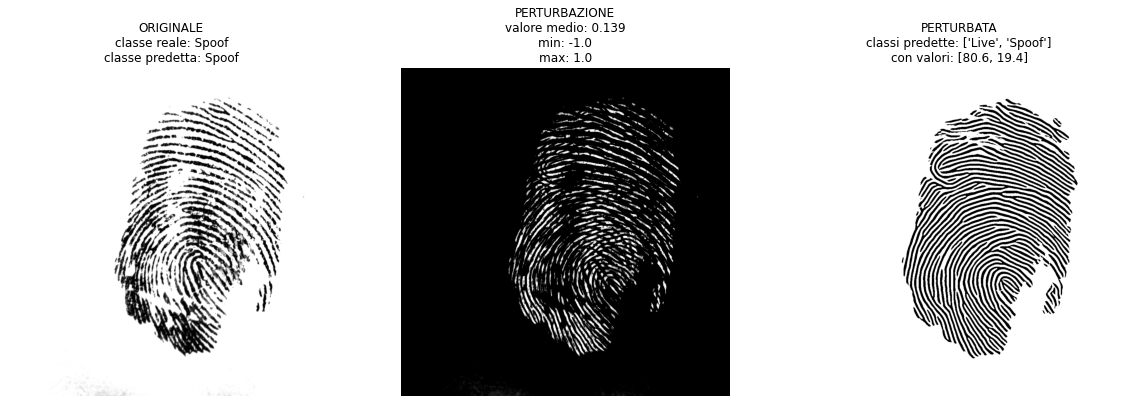

In [158]:
#da usare solo con dataset ridotto
preds_orig=[]
for input,_ in testgen:
  preds_orig_i,_,_=test_average(classifier,input,transf_init)
  preds_orig.append(preds_orig_i)
preds_orig=np.array(preds_orig)
#preds_orig=preds_orig[list_print]
preds_orig=np.array([classes_name[i] for i in preds_orig])
print_subplot(perturb_print,x_print,y_print,preds_orig,x_print_adv,y_print_adv)

#salvataggio e lettura immagine

In [ ]:
#for i in range(len(list_print)):  
save_read(np.array(x_print_adv[9]),classifier,transf_init)

valori img originale:
[0.00126301 0.99873704]
valori dopo salvataggio/lettura:
[0.00126301 0.99873704]


#Predizioni per immagini da drive prelevate singolarmente

In [ ]:
import os
Test_cagliari = pd.DataFrame()
path_cagliari="/content/gdrive/MyDrive/Dataset_cagliari/"
set_img="Latex_miei"
path_images=path_cagliari+set_img+"/"
directory = os.listdir(path_images)
i=0
for input in directory:
  i+=1
  sys.stdout.write("\rElem: {0}/{1}".format(i,len(directory)))
  sys.stdout.flush()
  img=cv2.imread(path_images+input)
  img=(img-np.min(img))/(np.max(img)-np.min(img))
  pred,probabilities,_=test_average(classifier,torch.Tensor(img.transpose(2,0,1)).unsqueeze_(0),transf_init)
  Test_cagliari = Test_cagliari.append({'name': input,
                                        'predicted': classes_name[pred], #qui metti pred
                                        'prob_live': probabilities[0]*100,
                                        'prob_spoof': probabilities[1]*100,},ignore_index = True)

Elem: 250/250

In [ ]:
p=Test_cagliari.loc[Test_cagliari['predicted']=='Live']
print(p)

                           name predicted  prob_live  prob_spoof
161  GreenBit_Latex_007_0_9.png      Live  97.842944    2.157059
172  GreenBit_Latex_007_6_9.png      Live  76.388419   23.611577


In [ ]:
Test_cagliari.to_excel(path_cagliari+set_img+".xlsx",index=False)